# RLCT Estimation of MNIST

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/mnist.ipynb)

This Jupyter Notebook aims to reproduce the results of Lau et al. (2023) by measuring the Real Log Canonical Threshold (RLCT) for a small 2-layer ReLU model (about 1M parameters) trained on the MNIST dataset. It uses both Stochastic Gradient Nose-Hoover Thermostat (SGNHT) and Stochastic Gradient Langevin Dynamics (SGLD) as sampling methods.

## Main Steps:

1. **Data Preparation**: Load the MNIST dataset for training and testing.
2. **Model Training**: Train a multi-layer perceptron model using stochastic gradient descent.
3. **Model Evaluation**: Evaluate the model's performance on a test set.
4. **RLCT Estimation**: Use SGNHT and SGLD samplers to estimate RLCT.
5. **Plotting**: Visualize train and test losses, and RLCT estimates.

In [1]:
%pip install --upgrade pip
%pip install transformers torch torchvision seaborn
%pip install devinterp

!git clone https://github.com/ucla-vision/entropy-sgd.git
%cd entropy-sgd
from python.optim import EntropySGD  
%cd ..



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
fatal: destination path 'entropy-sgd' already exists and is not an empty directory.
/home/svwin/devinterp/examples/entropy-sgd
/home/svwin/devinterp/examples


In [2]:
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PRIMARY, SECONDARY, TERTIARY, QUATERNARY = sns.color_palette("muted")[:4]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT, QUATERNARY_LIGHT = sns.color_palette(
    "pastel"
)[:4]

In [3]:
def emtpy_func():
    return (), ()


def train_one_epoch(model, train_loader, optimizer, criterion, model_key):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        if model_key == "sgd":
            optimizer.step()
        else:
            optimizer.step(emtpy_func, model, criterion)
    return train_loss / len(train_loader)


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)


# Define the neural network
class Net(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        activation=F.relu,
        with_bias=True,
    ):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

In [4]:
# Constants
DEVICE = "cpu"
BATCH_SIZE = 512
LR = 0.05
MOMENTUM = 0.9
N_EPOCHS = 10
DATA_PATH = "../data"


# Load MNIST dataset
def load_mnist_data(train, batch_size, shuffle):
    dataset = datasets.MNIST(
        DATA_PATH, train=train, transform=transforms.ToTensor(), download=True
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


train_loader = load_mnist_data(train=True, batch_size=BATCH_SIZE, shuffle=True)
test_loader = load_mnist_data(train=False, batch_size=BATCH_SIZE, shuffle=False)

model_esgd = Net().to(DEVICE)
model_sgd = Net().to(DEVICE)
optimizer_esgd = EntropySGD(
    model_esgd.parameters(), config=dict(lr=LR, momentum=MOMENTUM, L=5)
)
optimizer_sgd = optim.SGD(
    model_sgd.parameters(), lr=LR, momentum=MOMENTUM, nesterov=True
)

criterion = nn.CrossEntropyLoss()

In [5]:
train_losses, test_losses, models_saved = {}, {}, {}
for model_key, model, optimizer in [
    ("esgd", model_esgd, optimizer_esgd),
    ("sgd", model_sgd, optimizer_sgd),
]:
    train_losses[model_key] = []
    test_losses[model_key] = []
    models_saved[model_key] = []

    for epoch in range(N_EPOCHS):
        train_loss = train_one_epoch(
            model, train_loader, optimizer, criterion, model_key
        )
        test_loss = evaluate(model, test_loader, criterion)
        train_losses[model_key].append(train_loss)
        test_losses[model_key].append(test_loss)
        models_saved[model_key] += [copy.deepcopy(model)]

        print(
            f"Epoch {epoch+1}, Model {model_key.upper()} Train Loss: {train_loss}, Test Loss: {test_loss}"
        )

  0%|          | 0/118 [00:00<?, ?it/s]/home/svwin/devinterp/examples/entropy-sgd/python/optim.py:72: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1630.)
  mdw.mul_(mom).add_(1-damp, dw)
100%|██████████| 118/118 [00:40<00:00,  2.94it/s]


Epoch 1, Model ESGD Train Loss: 0.4335809538803868, Test Loss: 0.13750658445060254


100%|██████████| 118/118 [00:36<00:00,  3.26it/s]


Epoch 2, Model ESGD Train Loss: 0.09847117662114108, Test Loss: 0.09295670874416828


100%|██████████| 118/118 [00:35<00:00,  3.30it/s]


Epoch 3, Model ESGD Train Loss: 0.06105728120685129, Test Loss: 0.08635641876608133


100%|██████████| 118/118 [00:36<00:00,  3.27it/s]


Epoch 4, Model ESGD Train Loss: 0.042444939914522535, Test Loss: 0.07201294507831335


100%|██████████| 118/118 [00:37<00:00,  3.17it/s]


Epoch 5, Model ESGD Train Loss: 0.029058475694540193, Test Loss: 0.09353550090454518


100%|██████████| 118/118 [00:38<00:00,  3.10it/s]


Epoch 6, Model ESGD Train Loss: 0.02338095345155541, Test Loss: 0.0666468305978924


100%|██████████| 118/118 [00:40<00:00,  2.89it/s]


Epoch 7, Model ESGD Train Loss: 0.014942983145651928, Test Loss: 0.05922818561084568


100%|██████████| 118/118 [00:39<00:00,  2.95it/s]


Epoch 8, Model ESGD Train Loss: 0.01011295630734698, Test Loss: 0.06565013476647437


100%|██████████| 118/118 [00:36<00:00,  3.20it/s]


Epoch 9, Model ESGD Train Loss: 0.0061789901514727056, Test Loss: 0.0696030636318028


100%|██████████| 118/118 [00:32<00:00,  3.60it/s]


Epoch 10, Model ESGD Train Loss: 0.004073150214735198, Test Loss: 0.06419831463135779


100%|██████████| 118/118 [00:08<00:00, 13.30it/s]


Epoch 1, Model SGD Train Loss: 0.7004387070566921, Test Loss: 0.2828863725066185


100%|██████████| 118/118 [00:07<00:00, 16.17it/s]


Epoch 2, Model SGD Train Loss: 0.23466046905871166, Test Loss: 0.19284046292304993


100%|██████████| 118/118 [00:08<00:00, 14.37it/s]


Epoch 3, Model SGD Train Loss: 0.1647406288627851, Test Loss: 0.14092605970799923


100%|██████████| 118/118 [00:08<00:00, 14.10it/s]


Epoch 4, Model SGD Train Loss: 0.12335379093380297, Test Loss: 0.12548894863575696


100%|██████████| 118/118 [00:08<00:00, 13.83it/s]


Epoch 5, Model SGD Train Loss: 0.09699086554474749, Test Loss: 0.09859113926067949


100%|██████████| 118/118 [00:08<00:00, 14.50it/s]


Epoch 6, Model SGD Train Loss: 0.0778600609214124, Test Loss: 0.10147379748523236


100%|██████████| 118/118 [00:09<00:00, 12.56it/s]


Epoch 7, Model SGD Train Loss: 0.06445520876322762, Test Loss: 0.09041999075561762


100%|██████████| 118/118 [00:07<00:00, 15.91it/s]


Epoch 8, Model SGD Train Loss: 0.054622358042683644, Test Loss: 0.07841847073286771


100%|██████████| 118/118 [00:09<00:00, 11.94it/s]


Epoch 9, Model SGD Train Loss: 0.045365470824605326, Test Loss: 0.07236909312196076


100%|██████████| 118/118 [00:07<00:00, 15.23it/s]


Epoch 10, Model SGD Train Loss: 0.038058257346057285, Test Loss: 0.06791319558396935


In [6]:
from devinterp.slt.sampler import estimate_learning_coeff
from devinterp.utils import evaluate_ce


def estimate_rlcts(models, train_loader, device):
    estimates = {"sgnht": [], "sgld": []}
    for model in tqdm(models):
        for method, optimizer_kwargs in [
            ("sgnht", {"lr": 1e-7, "diffusion_factor": 0.01}),
            ("sgld", {"lr": 1e-5, "localization": 100.0}),
        ]:
            estimate = estimate_learning_coeff(
                model,
                train_loader,
                evaluate=evaluate_ce,
                optimizer_kwargs=optimizer_kwargs,
                sampling_method=SGNHT if method == "sgnht" else SGLD,
                num_chains=1,
                num_draws=400,
                num_burnin_steps=0,
                num_steps_bw_draws=1,
                device=device,
                verbose=False,
            )
            estimates[method].append(estimate)
    return estimates


data_length = len(train_loader.dataset)
rlct_esgd = estimate_rlcts(models_saved["esgd"], train_loader, DEVICE)
rlct_sgd = estimate_rlcts(models_saved["sgd"], train_loader, DEVICE)

  0%|          | 0/10 [00:00<?, ?it/s]/home/svwin/aether/.venv/lib/python3.8/site-packages/devinterp/backends/tpu/slt/sampler.py:310: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/svwin/aether/.venv/lib/python3.8/site-packages/devinterp/slt/llc.py:71: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.llc_std = self.llc_per_chain.std()
100%|██████████| 10/10 [07:05<00:00, 42.57s/it]


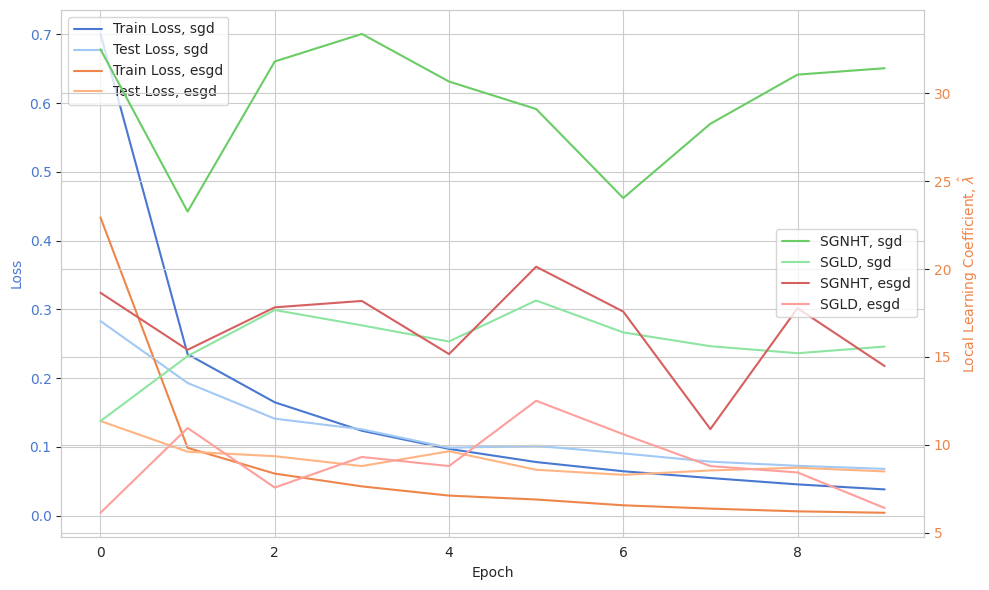

In [7]:
sns.set_style("whitegrid")

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=PRIMARY)
ax1.plot(train_losses["sgd"], label="Train Loss, sgd", color=PRIMARY)
ax1.plot(test_losses["sgd"], label="Test Loss, sgd", color=PRIMARY_LIGHT)

ax1.plot(train_losses["esgd"], label="Train Loss, esgd", color=SECONDARY)
ax1.plot(test_losses["esgd"], label="Test Loss, esgd", color=SECONDARY_LIGHT)
ax1.tick_params(axis="y", labelcolor=PRIMARY)
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.set_ylabel(r"Local Learning Coefficient, $\hat \lambda$", color=SECONDARY)
ax2.plot(rlct_sgd["sgnht"], label="SGNHT, sgd", color=TERTIARY)
ax2.plot(rlct_sgd["sgld"], label="SGLD, sgd", color=TERTIARY_LIGHT)

ax2.plot(rlct_esgd["sgnht"], label="SGNHT, esgd", color=QUATERNARY)
ax2.plot(rlct_esgd["sgld"], label="SGLD, esgd", color=QUATERNARY_LIGHT)
ax2.tick_params(axis="y", labelcolor=SECONDARY)
ax2.legend(loc="center right")

fig.tight_layout()
plt.show()